<a href="https://colab.research.google.com/github/mgnarag/painting_restoration/blob/main/Reflectance_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
!ls drive/My\ Drive
file_path = "/content/drive/MyDrive/Baumgartner screenshots/Reflectance_estimation/"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.decomposition import PCA
from scipy.io import loadmat
from PIL import Image

# **Estimating reflectance of Macbeth Color Chart:**

[[ 2.39346316 -2.02054944  1.01792283]
 [ 2.42267284  0.5259467  -1.1345829 ]
 [ 1.05518184  1.83733835  1.35594432]]
[[ 86610.40820657]
 [-14912.33396422]
 [ 12492.03154485]]
a shape (3, 1)
eigen shape (3, 61)


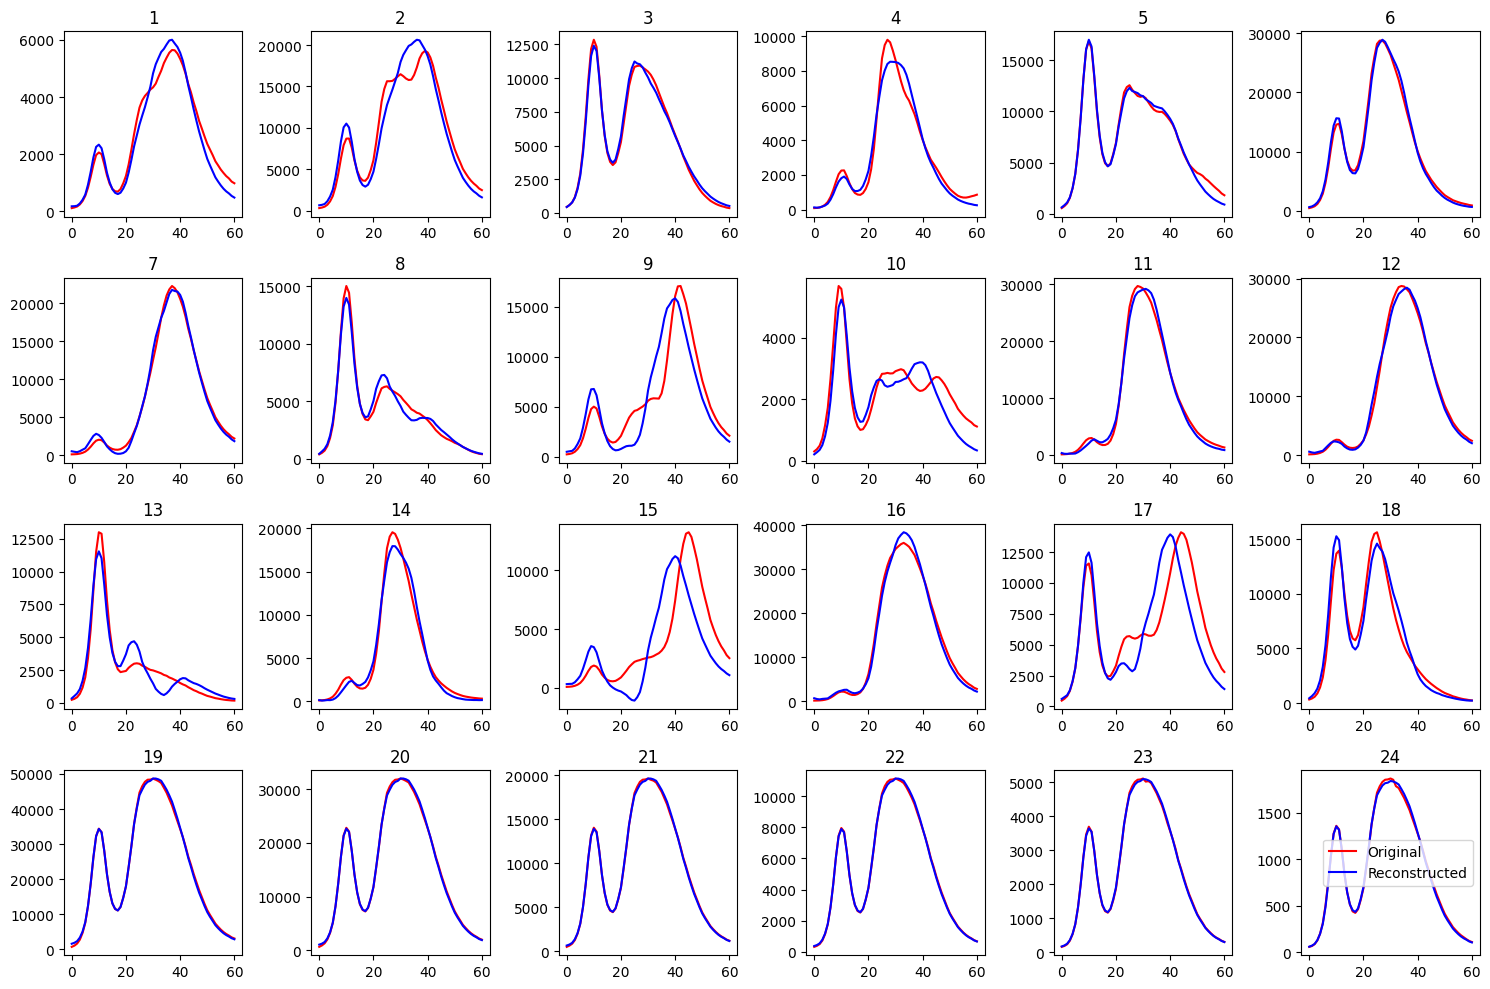

In [ ]:
# Step 1a: Reading the light source and Munsell
P_lambda = pd.read_excel(file_path+'LED_Array_3.xls', header=None).values
Lamda = np.arange(400, 705, 5)
interp_func = interp1d(P_lambda[:,0], P_lambda[:,1], fill_value="extrapolate")
P_lambda = interp_func(Lamda)

# Load Munsell reflectance data
munsell_data = loadmat(file_path+'munsell400_700_5.mat')
R_lambda = munsell_data['munsell']

# Step 2: Interpolate each column of R_lambda
interp_R_lambda = np.zeros((len(Lamda), R_lambda.shape[1]))  # Initialize the interpolated matrix

for i in range(R_lambda.shape[1]):
    interp_func = interp1d(np.arange(400, 705, 5), R_lambda[:, i], fill_value="extrapolate")  # Original data has 5 nm intervals
    interp_R_lambda[:, i] = interp_func(Lamda)  # Interpolate to the 1 nm interval

R_lambda = interp_R_lambda

# Step 1b: Getting the color signal
C_lambda = P_lambda[:, np.newaxis] * R_lambda


# Step 2: Computing eigenspectra of ensemble color signals
pca = PCA(n_components=3)
pca.fit(C_lambda.T)
eigen = pca.components_  # Get the first principal component


# Step 3: Computing transformation matrix T
data = np.loadtxt(file_path+'camera_8_spectra.txt')
Lambda_raw = data[:, 0]
S_R_raw = data[:, 1]
S_G_raw = data[:, 2]
S_B_raw = data[:, 3]

S_R = interp1d(Lambda_raw, S_R_raw, fill_value="extrapolate")(Lamda)
S_G = interp1d(Lambda_raw, S_G_raw, fill_value="extrapolate")(Lamda)
S_B = interp1d(Lambda_raw, S_B_raw, fill_value="extrapolate")(Lamda)
S_rgb = np.vstack((S_R, S_G, S_B)).T
T = S_rgb.T@ eigen.T
print(T)

# Step 4: Getting values of q
R_lambda_macbeth = pd.read_excel(file_path+'MacbethColorChecker.xlsx', header=None).values
range_mask = (R_lambda_macbeth[:, 0] > 399) & (R_lambda_macbeth[:, 0] < 701)
R_lambda_macbeth = R_lambda_macbeth[range_mask, :]

# Step 2: Interpolate each column of R_lambda
interp_R_lambda = np.zeros((len(Lamda), R_lambda_macbeth.shape[1]))  # Initialize the interpolated matrix

for i in range(R_lambda_macbeth.shape[1]):
    interp_func = interp1d(np.arange(400, 705, 5), R_lambda_macbeth[:, i], fill_value="extrapolate")  # Original data has 5 nm intervals
    interp_R_lambda[:, i] = interp_func(Lamda)  # Interpolate to the 1 nm interval

R_lambda_macbeth = interp_R_lambda


q_r, q_g, q_b = [], [], []

for i in range(1, 25):  # Index of Macbeth patches starts at i=2
    PRS_red = P_lambda * R_lambda_macbeth[:, i] * S_R
    q_r.append(np.sum(PRS_red))
    PRS_green = P_lambda * R_lambda_macbeth[:, i] * S_G
    q_g.append(np.sum(PRS_green))
    PRS_blue = P_lambda * R_lambda_macbeth[:, i] * S_B
    q_b.append(np.sum(PRS_blue))

# Applying the Wiener estimation
patch = 1
C1 = np.linalg.inv(T.T @ T)
C2 = C1 @ T.T
q = np.vstack((q_r[patch], q_g[patch], q_b[patch]))
a = C2 @ q
print(a)
print("a shape", a.shape)
print("eigen shape", eigen.shape)


# For all patches
fig, axs = plt.subplots(4, 6, figsize=(15, 10))
for patch in range(24):
    C1 = np.linalg.inv(T.T @ T)
    C2 = C1 @ T.T
    q = np.vstack((q_r[patch], q_g[patch], q_b[patch]))
    a = C2 @ q
    color_spectra_macbeth = P_lambda * R_lambda_macbeth[:, patch + 1]
    C3 = eigen.T @ a

    axs[patch // 6, patch % 6].plot(color_spectra_macbeth, '-r', label='Original')
    axs[patch // 6, patch % 6].plot(C3, '-b', label='Reconstructed')
    axs[patch // 6, patch % 6].set_title(patch + 1)

plt.tight_layout()
plt.legend()
plt.show()

## **Showing the color**

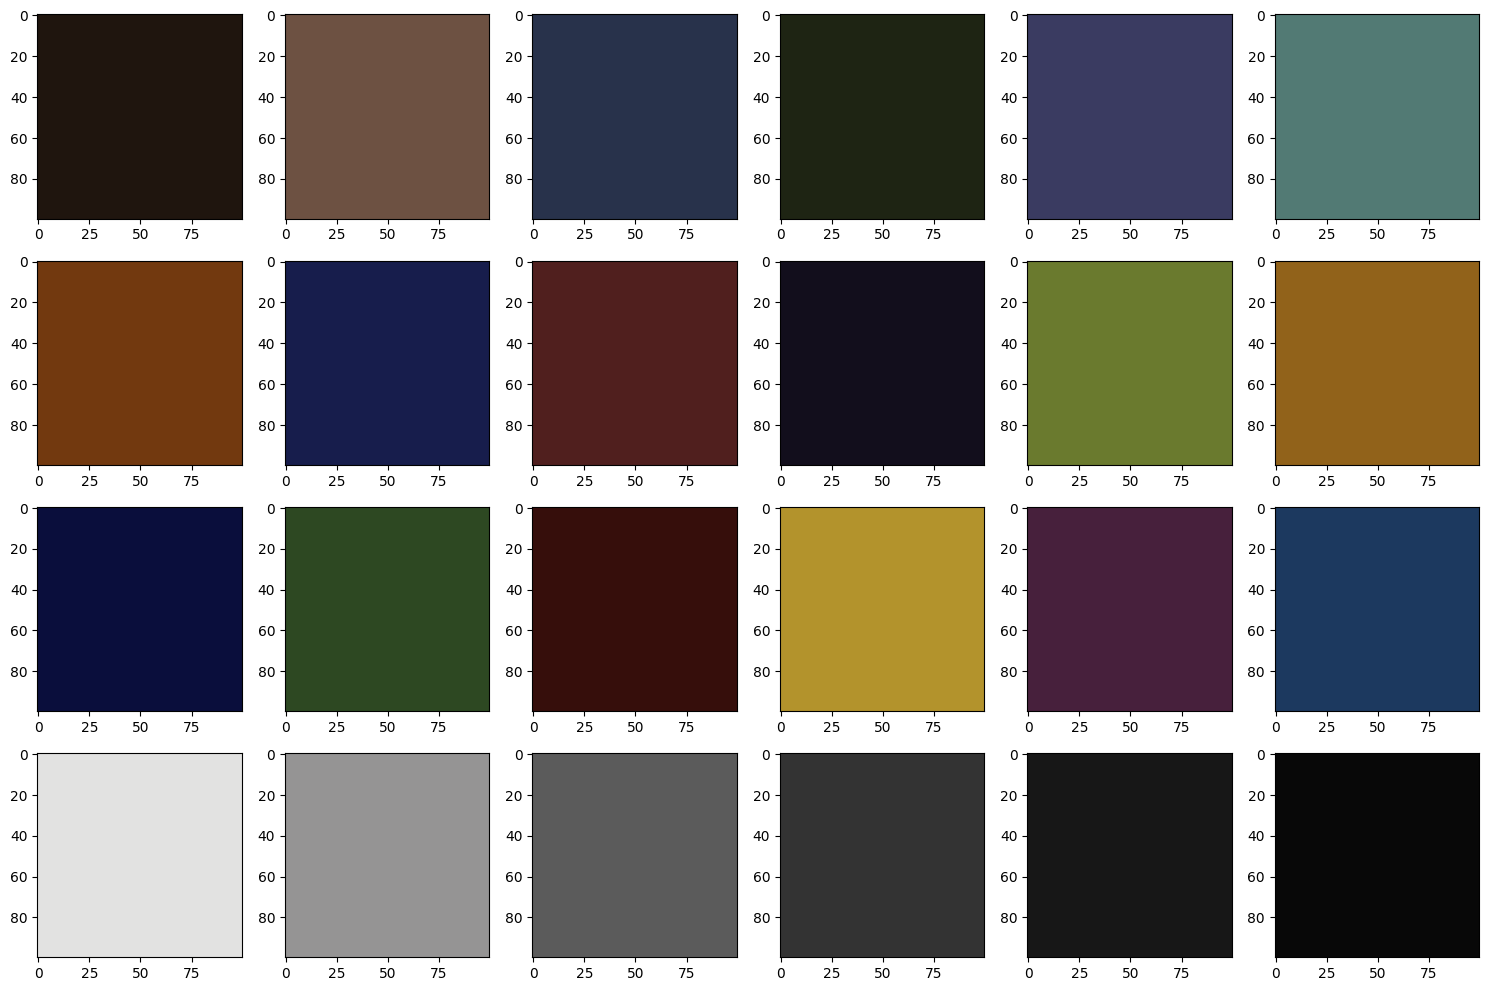

In [ ]:
# For all patches
fig, axs = plt.subplots(4, 6, figsize=(15, 10))
for patch in range(24):
    C1 = np.linalg.inv(T.T @ T)
    C2 = C1 @ T.T
    q = np.vstack((q_r[patch], q_g[patch], q_b[patch]))
    a = C2 @ q
    C3 = eigen.T @ a

    color_spectra_macbeth = P_lambda * R_lambda_macbeth[:, patch + 1]

    PRS_red = np.sum(C3[:,0]*S_R)
    PRS_green = np.sum(C3[:,0]*S_G)
    PRS_blue = np.sum(C3[:,0]*S_B)

    PS_red = np.sum(P_lambda*S_R)
    PS_green = np.sum(P_lambda*S_G)
    PS_blue = np.sum(P_lambda*S_B)
    V_red  = PRS_red/PS_red
    V_green  = PRS_green/PS_green
    V_blue  = PRS_blue/PS_blue

    PATCH_estimated = np.zeros((50, 100, 3), dtype=np.uint8)
    PATCH_estimated[:,:,0] = V_red*255
    PATCH_estimated[:,:,1] = V_green*255
    PATCH_estimated[:,:,2] = V_blue*255

    PRS_red = np.sum(P_lambda*S_R*R_lambda_macbeth[:, patch + 1])
    PRS_green = np.sum(P_lambda*S_G*R_lambda_macbeth[:, patch + 1])
    PRS_blue = np.sum(P_lambda*S_B*R_lambda_macbeth[:, patch + 1])

    PS_red = np.sum(P_lambda*S_R)
    PS_green = np.sum(P_lambda*S_G)
    PS_blue = np.sum(P_lambda*S_B)
    V_red  = PRS_red/PS_red
    V_green  = PRS_green/PS_green
    V_blue  = PRS_blue/PS_blue


    PATCH_theo = np.zeros((50, 100, 3), dtype=np.uint8)
    PATCH_theo[:,:,0] = V_red*255
    PATCH_theo[:,:,1] = V_green*255
    PATCH_theo[:,:,2] = V_blue*255

    PATCH = np.concatenate((PATCH_estimated, PATCH_theo), axis=0)

    axs[patch // 6, patch % 6].imshow(PATCH)
    #axs[patch // 6, patch % 6].plot(color_spectra_macbeth, '-r', label='Original')
    #axs[patch // 6, patch % 6].plot(C3, '-b', label='Reconstructed')
    #axs[patch // 6, patch % 6].set_title(patch + 1)

plt.tight_layout()
plt.show()

# **Code for estimating the reflectance:**

In [16]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from sklearn.decomposition import PCA
from scipy.io import loadmat

class ReflectanceCalculator:
    def __init__(self, light_source_file, camera_sensitivity_file, munsell_file):
        # Load light source
        P_lambda_raw = pd.read_excel(light_source_file, header=None).values
        self.Lamda = np.arange(400, 705, 5)
        interp_func = interp1d(P_lambda_raw[:, 0], P_lambda_raw[:, 1], fill_value="extrapolate")
        self.P_lambda = interp_func(self.Lamda)

        # Load Munsell reflectance data
        munsell_data = loadmat(munsell_file)
        self.R_lambda = munsell_data['munsell']

        # Compute color signal
        self.C_lambda = self.P_lambda[:, np.newaxis] * self.R_lambda

        # Perform PCA once to compute the eigenspectra
        pca = PCA(n_components=3)
        pca.fit(self.C_lambda.T)
        self.eigen = pca.components_

        # Load camera sensitivity
        camera_data = np.loadtxt(camera_sensitivity_file)
        Lambda_raw = camera_data[:, 0]
        S_R_raw = camera_data[:, 1]
        S_G_raw = camera_data[:, 2]
        S_B_raw = camera_data[:, 3]

        S_R = interp1d(Lambda_raw, S_R_raw, fill_value="extrapolate")(self.Lamda)
        S_G = interp1d(Lambda_raw, S_G_raw, fill_value="extrapolate")(self.Lamda)
        S_B = interp1d(Lambda_raw, S_B_raw, fill_value="extrapolate")(self.Lamda)
        self.S_rgb = np.vstack((S_R, S_G, S_B)).T

        # Compute transformation matrix T once
        self.T = self.S_rgb.T @ self.eigen.T

    def compute_reflectance(self, RGB):
        # Step 4: Calculate reflectance for given RGB using preloaded data
        C1 = np.linalg.inv(self.T.T @ self.T)
        C2 = C1 @ self.T.T
        q = np.vstack((RGB[0], RGB[1], RGB[2]))
        a = C2 @ q

        # Reconstruct reflectance
        reflectance = self.eigen.T @ a
        return reflectance

def load_image(image_path):
        # Load image in RGB format
        image = cv2.imread(image_path)
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def to_RGB(reflectance):
    PRS_red = np.sum(P_lambda*reflectance*S_R)
    PRS_green = np.sum(P_lambda*reflectance*S_G)
    PRS_blue = np.sum(P_lambda*reflectance*S_B)

    PS_red = np.sum(P_lambda*S_R)
    PS_green = np.sum(P_lambda*S_G)
    PS_blue = np.sum(P_lambda*S_B)

    V_red  = PRS_red/PS_red
    V_green  = PRS_green/PS_green
    V_blue  = PRS_blue/PS_blue
    return [V_red*255, V_green*255, V_blue*255]

## **Testing on paintings**

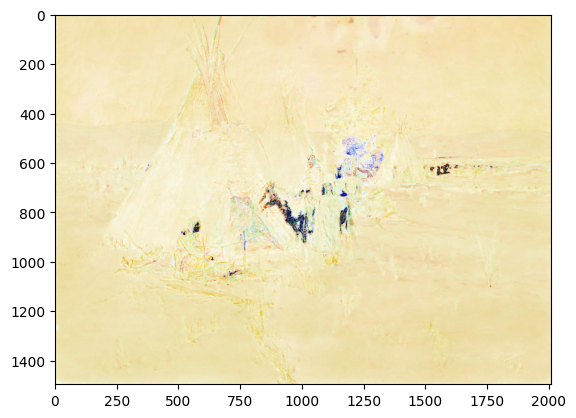

In [31]:
import cv2

light_source_file = file_path+'LED_Array_3.xls'
camera_sensitivity_file = file_path+'camera_8_spectra.txt'
munsell_file = file_path+'munsell400_700_5.mat'

P_lambda_raw = pd.read_excel(light_source_file, header=None).values
Lamda = np.arange(400, 705, 5)
interp_func = interp1d(P_lambda_raw[:, 0], P_lambda_raw[:, 1], fill_value="extrapolate")
P_lambda = interp_func(Lamda)

camera_data = np.loadtxt(camera_sensitivity_file)
Lambda_raw = camera_data[:, 0]
S_R_raw = camera_data[:, 1]
S_G_raw = camera_data[:, 2]
S_B_raw = camera_data[:, 3]

S_R = interp1d(Lambda_raw, S_R_raw, fill_value="extrapolate")(Lamda)
S_G = interp1d(Lambda_raw, S_G_raw, fill_value="extrapolate")(Lamda)
S_B = interp1d(Lambda_raw, S_B_raw, fill_value="extrapolate")(Lamda)

calculator = ReflectanceCalculator(light_source_file, camera_sensitivity_file, munsell_file)

image1_path = file_path+'Paintings/[08-Before]Preserve and Protect-2.png'
image2_path = file_path+'Paintings/[08-After]Preserve and Protect-2.png'

image1 = load_image(image1_path)
height, width, _ = image1.shape
reflectance_image1 = np.zeros((height, width, 61), dtype=np.float32)

# Iterate over every pixel and compute reflectance
for i in range(image1.shape[0]):
    for j in range(image1.shape[1]):
        RGB = image1[i, j]
        reflectance_image1[i, j] = calculator.compute_reflectance(RGB).flatten()  # Use .flatten() to fix the shape

image2 = load_image(image2_path)
height, width, _ = image2.shape
reflectance_image2 = np.zeros((height, width, 61), dtype=np.float32)

# Iterate over every pixel and compute reflectance
for i in range(image2.shape[0]):
    for j in range(image2.shape[1]):
        RGB = image2[i, j]
        reflectance_image2[i, j] = calculator.compute_reflectance(RGB).flatten()  # Use .flatten() to fix the shape

dirt_layer = reflectance_image1 / reflectance_image2
dirt_layer = dirt_layer/np.max(dirt_layer)
dirt_layer.shape

# Create an empty array to store the RGB colors
color_image = np.zeros((dirt_layer.shape[0], dirt_layer.shape[1], 3), dtype=np.uint8)

# Iterate over every pixel in divided_image and convert the 61-length vector to RGB
for i in range(dirt_layer.shape[0]):
    for j in range(dirt_layer.shape[1]):
        rgb = to_RGB(dirt_layer[i, j])  # Call the to_RGB function
        color_image[i, j] = rgb  # Assign the RGB values to the color image
#plt.imshow(color_image)

dirt_layer = reflectance_image1 / reflectance_image2
#dirt_layer = dirt_layer/np.max(dirt_layer)
dirt_layer.shape

# Create an empty array to store the RGB colors
color_image = np.zeros((dirt_layer.shape[0], dirt_layer.shape[1], 3), dtype=np.uint8)

# Iterate over every pixel in divided_image and convert the 61-length vector to RGB
for i in range(dirt_layer.shape[0]):
    for j in range(dirt_layer.shape[1]):
        x = dirt_layer[i, j]/np.max(dirt_layer[i, j])
        rgb = to_RGB(x)  # Call the to_RGB function
        color_image[i, j] = rgb  # Assign the RGB values to the color image
plt.imshow(color_image)

color_image_array = Image.fromarray(color_image)
color_image_array.save(file_path+'Paintings/Dirt Layer of Painting 3 from Actual.png')

# **Patch test**

RGB values =  [0.82423127 0.75701666 0.7252357  0.71949774 0.7084759  0.69798356
 0.69944304 0.6969178  0.6939512  0.6917062  0.6901766  0.69016665
 0.69226795 0.69290096 0.6945846  0.697174   0.7024154  0.7098154
 0.7216488  0.73087627 0.7434468  0.7639755  0.7994048  0.8361246
 0.8722268  0.9169779  0.9704249  1.0104055  1.0460505  1.0847851
 1.1227     1.1612828  1.1824917  1.200581   1.2109859  1.204571
 1.1922828  1.1724613  1.156703   1.1436769  1.127528   1.1151187
 1.1059482  1.1036196  1.0995011  1.0928645  1.0819751  1.0724025
 1.0657135  1.060629   1.0531573  1.0486617  1.0441186  1.0388325
 1.0358309  1.0348681  1.0359908  1.0352794  1.0396311  1.0347118
 1.0309469 ]


TypeError: 'numpy.uint8' object is not iterable

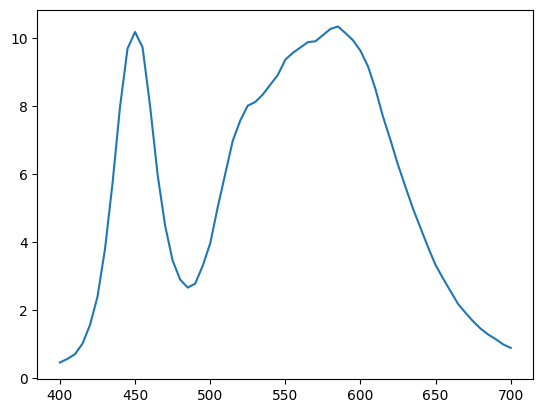

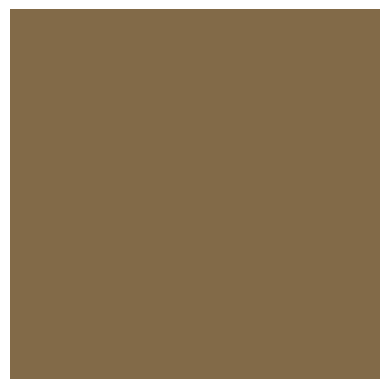

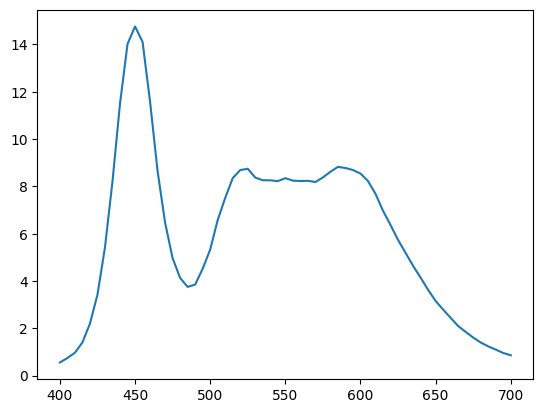

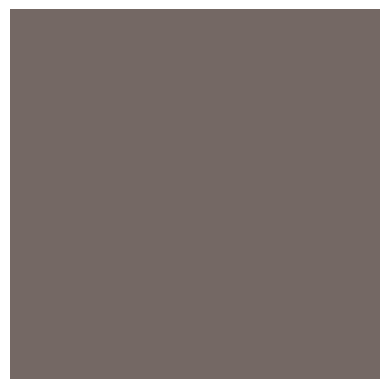

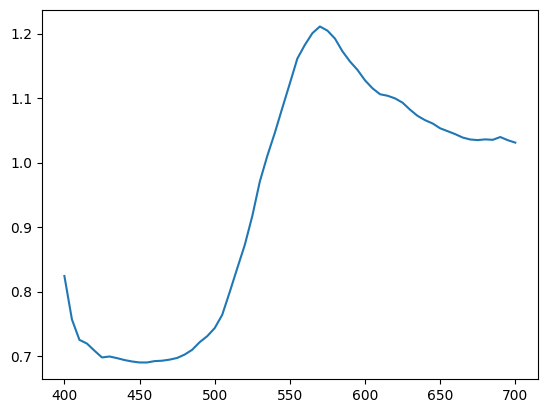

In [ ]:
dirt_layer[1400,200]
print("RGB values = ", dirt_layer[1400,200])
plt.figure()
plt.plot(Lamda,reflectance_image1[1400,200])
PATCH = np.zeros((50, 50, 3), dtype=np.uint8)
PATCH[:,:,0] = image1[1400,200][0]
PATCH[:,:,1] = image1[1400,200][1]
PATCH[:,:,2] = image1[1400,200][2]
plt.figure()
plt.imshow(PATCH)
plt.axis('off')

dirt_layer[1400,200]
plt.figure()
plt.plot(Lamda,reflectance_image2[1400,200])
PATCH = np.zeros((50, 50, 3), dtype=np.uint8)
PATCH[:,:,0] = image2[1400,200][0]
PATCH[:,:,1] = image2[1400,200][1]
PATCH[:,:,2] = image2[1400,200][2]
plt.figure()
plt.imshow(PATCH)
plt.axis('off')


dirt_layer[1400,200]
plt.figure()
plt.plot(Lamda,dirt_layer[1400,200])
PATCH = np.zeros((50, 50, 3), dtype=np.uint8)
PATCH[:,:,0] = color_image[1400,200][0]
PATCH[:,:,1] = color_image[1400,200][1]
PATCH[:,:,2] = color_image[1400,200][2]
plt.figure()
plt.imshow(PATCH)
plt.axis('off')